In [1]:
import os

QM9_path = os.environ["DATA"] + "/00_datasets/DFT/QM9/filtered_QM9_charges_radicals_stereo.smi"
ChEMBL_CNOF_path = os.environ["DATA"] + "/00_datasets/ChEMBL25/filtered_ChEMBL_charges_radicals_stereo_CNOF.smi"


output_data_path = os.environ["DATA"] + "/07_BBO/02_models/these/02.01_QED_prediction_v2_thèse_save_intramodel_error/"
output_fig_path = os.environ["FIGURES"] + "/07_BBO/04_BBO_chem/01_QED/v2_thèse_save_intramodel_error/"

os.makedirs(output_fig_path, exist_ok=True)
os.makedirs(output_data_path, exist_ok=True)

N_JOBS = 10
CV = 100

In [2]:
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, DotProduct

kernels = [
    ("RBF", 1.0*RBF(1.0) + WhiteKernel(1.0)),
    ("DotProduct", 1.0*DotProduct(1.0) + WhiteKernel(1.0))
]

In [3]:
import csv
from evomol.evaluation import QEDEvaluationStrategy
import numpy as np

def load_smiles_dataset(path):
    
    all_smiles = []
    
    with open(path, "r") as f:
        reader = csv.reader(f)
        for row in reader:
            all_smiles.append(row[0])
            
    np.random.shuffle(all_smiles)
    return all_smiles
        

def compute_QED(dataset_smiles):
    
    s = QEDEvaluationStrategy()
    return [s.eval_smi(smi) for smi in dataset_smiles]

In [4]:
QM9_smiles = load_smiles_dataset(QM9_path)
ChEMBL_smiles = load_smiles_dataset(ChEMBL_CNOF_path)

print(len(QM9_smiles))
print(len(ChEMBL_smiles))

132040
867606


In [5]:


import numpy as np

def gen_splits(size, n_splits):
    
    for i in range(n_splits):
        
        train_idx = np.arange(i*size, i*size + size)
        test_idx = np.array(np.setdiff1d(np.arange(n_splits*size), train_idx))
        yield train_idx, test_idx
        

In [6]:
gen_splits(1000, 100)

<generator object gen_splits at 0x7f7f8e2f9468>

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from chemdesc.descriptors import ShinglesVectDesc
from tqdm import tqdm
import time
from sklearn.model_selection import cross_validate

def procedure(complete_smiles_list, kernels, test_on=None):
    
    desc_builer = ShinglesVectDesc(cache_location=None, count=True, vect_size=2000)
    qed_eval = QEDEvaluationStrategy()
    
    output_dict = {}
    
    smiles_list = complete_smiles_list[:100000]
    
#     smiles_list = complete_smiles_list[:1000]
   


    X = desc_builer.fit_transform(smiles_list)[0]
    y = []
    for smi in tqdm(smiles_list):
        y.append(qed_eval.eval_smi(smi))
    
    for kernel_tuple in kernels:
        
        generator = gen_splits(1000, 100)
        
#         generator = gen_splits(100, 10)
        
        
        output_dict[kernel_tuple[0]] = {}
        
        kernel = kernel_tuple[1]
        model = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
        
        results = cross_validate(model, X, y, scoring="neg_mean_absolute_error", cv=generator, n_jobs=N_JOBS,
                                 return_estimator=True, verbose=10)
        
        output_dict[kernel_tuple[0]]["scores"] = list(results["test_score"])
        output_dict[kernel_tuple[0]]["fit_times"] = list(results["fit_time"])
        output_dict[kernel_tuple[0]]["score_times"] = list(results["score_time"])
        
        
        generator = gen_splits(1000, 100)
        
#         generator = gen_splits(100, 10)
        
        train_idx, test_idx = next(generator)
        
        first_fold_estimator = results["estimator"][0]
        y_pred = first_fold_estimator.predict(X[test_idx])
        y_test = np.array(y)[test_idx]
        output_dict[kernel_tuple[0]]["first_fold_error"] = (y_test - y_pred).tolist()
        
    
          
    return output_dict

In [8]:
# train_QM9_test_QM9 = procedure(QM9_smiles, kernels)

In [9]:
train_QM9_test_QM9

NameError: name 'train_QM9_test_QM9' is not defined

In [10]:
# train_ChEMBL_test_ChEMBL = procedure(ChEMBL_smiles, kernels)

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", color_codes=True)
    
    

In [12]:
# import json
# from os.path import join

# with open(join(output_data_path, "QM9_results.json"), "w") as f:
#     json.dump(train_QM9_test_QM9, f)

# with open(join(output_data_path, "ChEMBL_results.json"), "w") as f:
#     json.dump(train_ChEMBL_test_ChEMBL, f)

In [13]:
import json
from os.path import join

with open(join(output_data_path, "QM9_results.json"), "r") as f:
    QM9_results = json.load(f)
    
with open(join(output_data_path, "ChEMBL_results.json"), "r") as f:
    ChEMBL_results = json.load(f)

In [14]:
train_QM9_test_QM9 = QM9_results
train_ChEMBL_test_ChEMBL = ChEMBL_results

In [15]:

def plot_results(results_dict, dataset_name):
    
    print(dataset_name)
    for kernel in ["RBF", "DotProduct"]:
        print(kernel)
        data = -np.array(results_dict[kernel]["scores"])
        print("Moyenne : " + str(np.mean(data)))
        print("Médiane : " + str(np.median(data)))
        print("Stddev : " + str(np.std(data)))
        print("Max : " + str(np.max(data)))
        print()


In [16]:
plot_results(QM9_results, "QM9")

QM9
RBF
Moyenne : 0.031129061806574473
Médiane : 0.031081995461575786
Stddev : 0.00042946707455002604
Max : 0.03253440066106678

DotProduct
Moyenne : 0.03708591797241068
Médiane : 0.037063367855683135
Stddev : 0.00035636353003176945
Max : 0.038277632447938664



In [17]:
plot_results(ChEMBL_results, "ChEMBL")

ChEMBL
RBF
Moyenne : 0.07812833926953176
Médiane : 0.0781992840414966
Stddev : 0.0009454930836368734
Max : 0.08077193552781692

DotProduct
Moyenne : 0.10237613490164393
Médiane : 0.10209913594090092
Stddev : 0.0013182649478952525
Max : 0.10576881765818812



In [18]:
QM9_results

{'RBF': {'scores': [-0.031209511129158984,
   -0.030287378001438128,
   -0.03158788565239864,
   -0.030913617904112123,
   -0.030886447555880377,
   -0.030851945812176308,
   -0.031082720876958042,
   -0.031153632954816247,
   -0.03133874096281162,
   -0.030444587155521823,
   -0.03114322576069475,
   -0.03131466875248729,
   -0.03129983836246877,
   -0.030657289476882663,
   -0.031028311990636562,
   -0.030346179323787456,
   -0.031414962187820146,
   -0.031059552856515387,
   -0.03098760337442767,
   -0.03110540116917115,
   -0.031548788728180434,
   -0.032008076919039195,
   -0.030739811473986585,
   -0.030592518901992178,
   -0.030940108322712614,
   -0.030812082895775236,
   -0.032249319453923016,
   -0.030722580330855218,
   -0.031502714780013506,
   -0.03132107335304629,
   -0.03253440066106678,
   -0.03196711167246075,
   -0.03180626637385182,
   -0.03111346050531792,
   -0.03102186685593673,
   -0.030783196849941484,
   -0.031483583202846506,
   -0.03080429197872563,
   -0.030

In [19]:
np.mean(np.absolute(train_QM9_test_QM9["RBF"]['errors_list']))

KeyError: 'errors_list'

In [20]:
np.mean(np.absolute(train_ChEMBL_test_ChEMBL["RBF"]['errors_list']))

KeyError: 'errors_list'

In [21]:
np.median(np.absolute(train_QM9_test_QM9["RBF"]['errors_list']))

KeyError: 'errors_list'

In [22]:
np.median(np.absolute(train_ChEMBL_test_ChEMBL["RBF"]['errors_list']))

KeyError: 'errors_list'

In [23]:
np.max(np.absolute(train_QM9_test_QM9["RBF"]['errors_list']))

KeyError: 'errors_list'

In [24]:
np.max(np.absolute(train_ChEMBL_test_ChEMBL["RBF"]['errors_list']))

KeyError: 'errors_list'

In [25]:
np.mean(np.absolute(train_ChEMBL_test_QM9["RBF"]['errors_list']))

NameError: name 'train_ChEMBL_test_QM9' is not defined

In [26]:
np.mean(np.absolute(train_QM9_test_ChEMBL["RBF"]['errors_list']))

NameError: name 'train_QM9_test_ChEMBL' is not defined

In [27]:
np.mean(np.absolute(train_QM9_test_QM9["DotProduct"]['errors_list']))

KeyError: 'errors_list'

In [28]:
np.mean(np.absolute(train_ChEMBL_test_ChEMBL["DotProduct"]['errors_list']))

KeyError: 'errors_list'

In [29]:
np.median(np.absolute(train_QM9_test_QM9["DotProduct"]['errors_list']))

KeyError: 'errors_list'

In [30]:
np.median(np.absolute(train_ChEMBL_test_ChEMBL["DotProduct"]['errors_list']))

KeyError: 'errors_list'

In [31]:
np.max(np.absolute(train_QM9_test_QM9["DotProduct"]['errors_list']))

KeyError: 'errors_list'

In [32]:
np.max(np.absolute(train_ChEMBL_test_ChEMBL["DotProduct"]['errors_list']))

KeyError: 'errors_list'

In [33]:
np.mean(np.absolute(train_ChEMBL_test_QM9["DotProduct"]['errors_list']))

NameError: name 'train_ChEMBL_test_QM9' is not defined

In [34]:
np.mean(np.absolute(train_QM9_test_ChEMBL["DotProduct"]['errors_list']))

NameError: name 'train_QM9_test_ChEMBL' is not defined

In [35]:
def plot_distrib_errors(train_QM9_test_QM9, train_ChEMBL_test_ChEMBL):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6), sharex=True, sharey=True)
    
    for t in [(ax1, "RBF"), (ax2, "DotProduct")]:
        
#         for exp in [(train_QM9_test_QM9, "QM9 - QM9"), (train_ChEMBL_test_ChEMBL, "ChEMBL - ChEMBL"),
#                     (train_QM9_test_ChEMBL, "QM9 - ChEMBL"), (train_ChEMBL_test_QM9, "ChEMBL - QM9")]:
            
        for exp in [(train_QM9_test_QM9, "QM9"), (train_ChEMBL_test_ChEMBL, "ChEMBL")]:
            
            print(np.max(np.absolute(np.array(exp[0][t[1]]["errors_list"]).flatten())))
    
            sns.distplot(np.absolute(np.array(exp[0][t[1]]["errors_list"]).flatten()), ax=t[0], label=exp[1],
                         kde=False, bins=np.linspace(0, 0.85, 35))
            t[0].set_title("Fonction noyau : " + t[1])
            t[0].set_xlabel("Erreur moyenne absolue (MAE)")
#             plt.yscale("log")
            plt.xlim(0, 0.85)
            plt.legend()
    
    plt.savefig(join(output_fig_path, "QED_pred_dist_mae.png"), dpi=250)
        
            

KeyError: 'errors_list'

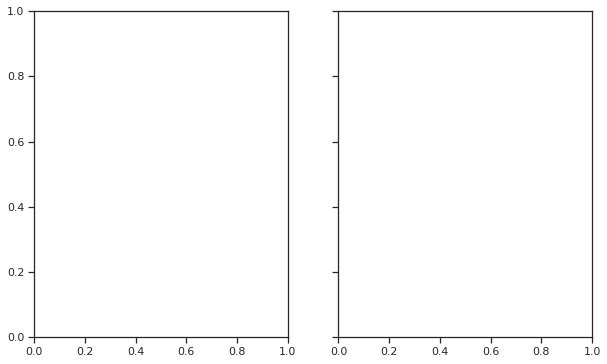

In [36]:
plot_distrib_errors(train_QM9_test_QM9, train_ChEMBL_test_ChEMBL)

In [ ]:
# def errors_vs_target(data, key):
#     plt.figure(figsize=(5, 7))
#     plt.scatter(np.array(data[key]["targets_list"]).flatten(), 
#                 np.array(data[key]["errors_list"]).flatten() + np.array(data[key]["targets_list"]).flatten(),
#                 alpha=0.2, marker=',',lw=0,s=1)
#     plt.plot([0, 1], [0, 1], color='g')
#     plt.xlim((0, 1))

In [ ]:
# errors_vs_target(train_ChEMBL_test_QM9, "RBF")

In [131]:
print(np.mean(ChEMBL_results["RBF"]["first_fold_error"]))
print(np.mean(ChEMBL_results["DotProduct"]["first_fold_error"]))
print(np.mean(QM9_results["RBF"]["first_fold_error"]))
print(np.mean(QM9_results["DotProduct"]["first_fold_error"]))

-0.004648158374187673
-0.006632069648869929
0.0007469284394646554
0.001007464858965767


In [132]:
print(np.std(ChEMBL_results["RBF"]["first_fold_error"]))
print(np.std(ChEMBL_results["DotProduct"]["first_fold_error"]))
print(np.std(QM9_results["RBF"]["first_fold_error"]))
print(np.std(QM9_results["DotProduct"]["first_fold_error"]))

0.09980888648659698
0.1289765235810644
0.04145532860532791
0.04780842178490199


In [127]:

def plot_intramodel_error(QM9_results, ChEMBL_results):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6), sharex=True, sharey=True)

    for t in [(ax1, "RBF"), (ax2, "DotProduct")]:
        t[0].set_title(t[1])
        sns.distplot(QM9_results[t[1]]["first_fold_error"], ax=t[0], label="QM9", kde=False, 
                     bins=np.arange(-0.4, 0.4, 0.02))
        sns.distplot(ChEMBL_results[t[1]]["first_fold_error"], ax=t[0], label="ChEMBL", kde=False, 
                     bins=np.arange(-0.4, 0.4, 0.02))

        t[0].set_xlabel("Erreur")
    plt.legend()
    

    plt.savefig(join(output_fig_path, "QED_intramodel_error_dist.png"), dpi=250)
        


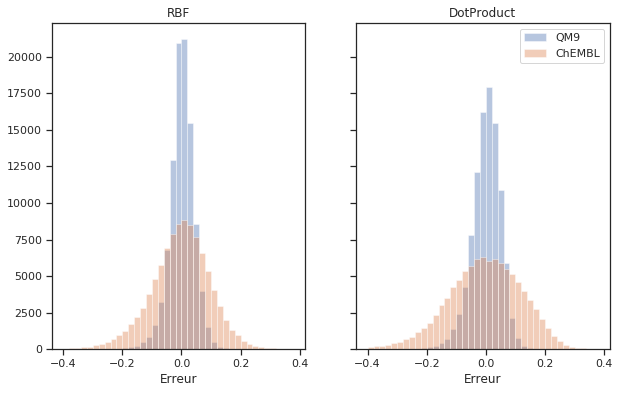

In [128]:
plot_intramodel_error(QM9_results, ChEMBL_results)

In [37]:
def eval_model(model, X_train, y_train, X_test, y_test, size):
    
    tstart = time.time()
    model.fit(X_train[:size], y_train[:size])
    fit_time = time.time() - tstart
    
    tstart = time.time()
    y_pred = model.predict(X_test)
    predict_time = time.time() - tstart
    
    MAE = np.mean(np.absolute(y_pred - y_test))
    
    return MAE, fit_time, predict_time
    

def data_efficiency_experiments(kernels, QM9_smiles, ChEMBL_smiles):
    
    output_dict = {kernel[0]: {
        "size": [],
        "QM9_fit_time": [],
        "QM9_predict_time": [],
        "QM9_MAE": [],
        "ChEMBL_fit_time": [],
        "ChEMBL_predict_time": [],
        "ChEMBL_MAE": []
    } for kernel in kernels}
    
    dataset_sizes = [10, 30, 100, 300, 1000, 3000, 10000]
    
    desc_builer = ShinglesVectDesc(cache_location=None, count=True, vect_size=2000)
    qed_eval = QEDEvaluationStrategy()
    
    QM9_train_smiles, QM9_test_smiles = train_test_split(QM9_smiles, test_size=50000)
    ChEMBL_train_smiles, ChEMBL_test_smiles = train_test_split(ChEMBL_smiles, test_size=50000)
    
    QM9_train_smiles = QM9_train_smiles[:10000]
    ChEMBL_train_smiles = ChEMBL_train_smiles[:10000]
    
    QM9_train_X = desc_builer.fit_transform(QM9_train_smiles)[0]
    QM9_test_X = desc_builer.fit_transform(QM9_test_smiles)[0]
    ChEMBL_train_X = desc_builer.fit_transform(ChEMBL_train_smiles)[0]
    ChEMBL_test_X = desc_builer.fit_transform(ChEMBL_test_smiles)[0]
    
    QM9_train_y = [qed_eval.eval_smi(smi) for smi in tqdm(QM9_train_smiles)]
    QM9_test_y = [qed_eval.eval_smi(smi) for smi in tqdm(QM9_test_smiles)]
    ChEMBL_train_y = [qed_eval.eval_smi(smi) for smi in tqdm(ChEMBL_train_smiles)]
    ChEMBL_test_y = [qed_eval.eval_smi(smi) for smi in tqdm(ChEMBL_test_smiles)]
    
    for kernel in kernels:
        print(kernel[0])
        model = GaussianProcessRegressor(kernel=kernel[1], normalize_y=True)
        
        for dataset_size in dataset_sizes:
            print(dataset_size)
            
            MAE_QM9, time_fit_QM9, time_predict_QM9 = eval_model(model, QM9_train_X, QM9_train_y, 
                                                                 QM9_test_X, QM9_test_y, 
                                                                 dataset_size)
            
            MAE_ChEMBL, time_fit_ChEMBL, time_predict_ChEMBL = eval_model(model, ChEMBL_train_X, ChEMBL_train_y, 
                                                                          ChEMBL_test_X, ChEMBL_test_y, 
                                                                          dataset_size)
            print(time_fit_ChEMBL)
            output_dict[kernel[0]]["size"].append(dataset_size)
            output_dict[kernel[0]]["QM9_fit_time"].append(time_fit_QM9)
            output_dict[kernel[0]]["QM9_predict_time"].append(time_predict_QM9)
            output_dict[kernel[0]]["QM9_MAE"].append(MAE_QM9)
            output_dict[kernel[0]]["ChEMBL_fit_time"].append(time_fit_ChEMBL)
            output_dict[kernel[0]]["ChEMBL_predict_time"].append(time_predict_ChEMBL)
            output_dict[kernel[0]]["ChEMBL_MAE"].append(MAE_ChEMBL)
            
    return output_dict
            

In [38]:
output_data_efficiency = data_efficiency_experiments(kernels, QM9_smiles, ChEMBL_smiles)

MM program : obabel_mmff94
None


100%|██████████| 50000/50000 [01:50<00:00, 450.55it/s]


RBF
10
0.015428781509399414
30
0.10293221473693848
100
0.25609636306762695
300
1.7725105285644531
1000
17.759260177612305
3000
126.70215821266174
10000
1623.6018073558807
DotProduct
10
0.05410289764404297
30
0.08786654472351074
100
0.04040336608886719
300
0.20915007591247559
1000
1.8731379508972168
3000
19.125490188598633
10000
407.80725049972534


In [ ]:
with open(join(output_data_path, "data_efficiency_results.json"), "w") as f:
    json.dump(output_data_efficiency, f)

In [39]:
def time_desc(QM9_smiles, ChEMBL_smiles):
        
    desc_builer = ShinglesVectDesc(cache_location=None, count=True, vect_size=2000)
    
    _, QM9_test_smiles = train_test_split(QM9_smiles, test_size=50000)
    _, ChEMBL_test_smiles = train_test_split(ChEMBL_smiles, test_size=50000)
    
    tstart = time.time()
    desc_builer.fit_transform(QM9_test_smiles)
    time_QM9_desc = time.time() - tstart
    
    tstart = time.time()
    desc_builer.fit_transform(ChEMBL_test_smiles)
    time_ChEMBL_desc = time.time() - tstart
    
    return time_QM9_desc, time_ChEMBL_desc

In [44]:
time_QM9_desc, time_ChEMBL_desc = time_desc(QM9_smiles, ChEMBL_smiles)

MM program : obabel_mmff94
None


100%|██████████| 50000/50000 [07:23<00:00, 112.63it/s]


In [45]:
time_QM9_desc/50

2.6813985252380372

In [46]:
time_ChEMBL_desc/50

8.878956780433654

In [73]:
import numpy as np
import pandas as pd
from os.path import join



def plot_data_efficiency(output_data_efficiency, time_QM9_desc, time_ChEMBL_desc):
    
    d = {"sizecol": [], "Données": [], "predict_time": [], "desc_predict_time": [], "fit_time": [], "MAE": [], 
         "Noyau": []} 
    
    k = "RBF"
    
    predict_time_denominateur = 50
    
    for k in ["RBF", "DotProduct"]:
        d["sizecol"].extend(output_data_efficiency[k]["size"])
        d["Données"].extend(np.full(len(output_data_efficiency[k]["size"],), "QM9"))
        d["Noyau"].extend(np.full(len(output_data_efficiency[k]["size"],), k))
        d["fit_time"].extend(output_data_efficiency[k]["QM9_fit_time"])
        d["predict_time"].extend(np.array(output_data_efficiency[k]["QM9_predict_time"])/predict_time_denominateur)
        d["desc_predict_time"].extend(np.array(output_data_efficiency[k]["QM9_predict_time"])/predict_time_denominateur + time_QM9_desc/predict_time_denominateur)
        d["MAE"].extend(output_data_efficiency[k]["QM9_MAE"])

        d["sizecol"].extend(output_data_efficiency[k]["size"])
        d["Données"].extend(np.full(len(output_data_efficiency[k]["size"],), "ChEMBL"))
        d["Noyau"].extend(np.full(len(output_data_efficiency[k]["size"],), k))
        d["fit_time"].extend(output_data_efficiency[k]["ChEMBL_fit_time"])
        d["predict_time"].extend(np.array(output_data_efficiency[k]["ChEMBL_predict_time"])/predict_time_denominateur)
        d["desc_predict_time"].extend(np.array(output_data_efficiency[k]["ChEMBL_predict_time"])/predict_time_denominateur + time_ChEMBL_desc/predict_time_denominateur)
        d["MAE"].extend(output_data_efficiency[k]["ChEMBL_MAE"])

        
    df = pd.DataFrame.from_dict(d)
    df = df[df.sizecol != 30]
    df = df[df.sizecol != 300]
    df = df[df.sizecol != 3000]



   
    plt.figure(figsize=(9, 6))
    sns.lineplot(data=df, x="sizecol", y="MAE", hue="Données", style="Noyau", legend="brief")
    plt.ylabel("Erreur moyenne absolue (MAE)")
    plt.xlabel("Taille des données d'entraînement")
    plt.ylim(0, 0.25)
    plt.xscale("log")
    
    plt.savefig(join(output_fig_path, "MAE.png"), dpi=250)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6), sharex=True) #sharey=True)

    
#     handles, labels = ax1.get_legend_handles_labels()
#     ax1.legend(handles=handles[:2], labels=labels, title="Whatever else")
#     ax1.legend(handles=handles[2:4], labels=labels, title="Whatever else")
    

    sns.lineplot(x="sizecol", y="fit_time", hue="Données", style="Noyau", data=df[df["Données"] == "QM9"], ax=ax1, legend=False)
#     sns.lineplot(x="sizecol", y="fit_time", hue="Données", style="Noyau", data=df[df["Données"] == "ChEMBL"], ax=ax1, legend=False)

    sns.lineplot(x="sizecol", y="predict_time", hue="Données", style="Noyau", data=df[df["Données"] == "QM9"], ax=ax2, legend=False)
#     sns.lineplot(x="sizecol", y="predict_time", hue="Données", style="Noyau", data=df[df["Données"] == "ChEMBL"], ax=ax2, legend=False)

    sns.lineplot(x="sizecol", y="desc_predict_time", hue="Données", style="Noyau", data=df, ax=ax3)
    
    ax1.set_xlabel("Taille des données d'entraînement")
    ax1.set_ylabel("Temps (s)")
    ax1.set_yscale("log")
    ax1.set_xscale("log")
    ax1.set_ylim(1e-3, 1e4)
    ax1.set_title("Entraînement")
    
    ax2.set_xlabel("Taille des données d'entraînement")
    ax2.set_ylabel("")
    ax2.set_yscale("log")
    ax2.set_xscale("log")
    ax2.set_ylim(1e-3, 1e4)
    ax2.set_title("Prédiction (1000 mol.)")
    
    ax3.set_xlabel("Taille des données d'entraînement")
    ax3.set_ylabel("")
    ax3.set_yscale("log")
    ax3.set_xscale("log")
    ax3.set_ylim(1e-3, 1e4)
    ax3.set_title("Descripteurs + prédiction (1000 mol.)")
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()
    plt.savefig(join(output_fig_path, "times.png"), dpi=250)
    
    return df

sizecol Données  predict_time  desc_predict_time     fit_time       MAE  \
0        10     QM9      0.013244           2.694642     0.237442  0.061930   
2       100     QM9      0.101566           2.782964     0.233968  0.043372   
4      1000     QM9      1.211544           3.892943    19.348161  0.031922   
6     10000     QM9     12.005998          14.687396  2217.531227  0.022966   
7        10  ChEMBL      0.015435           8.894392     0.015429  0.214592   
9       100  ChEMBL      0.101533           8.980490     0.256096  0.116161   
11     1000  ChEMBL      1.185145          10.064102    17.759260  0.077572   
13    10000  ChEMBL     11.948005          20.826962  1623.601807  0.052030   
14       10     QM9      0.002782           2.684180     0.036283  0.061580   
16      100     QM9      0.005932           2.687330     0.080555  0.044415   
18     1000     QM9      0.025720           2.707118     2.275424  0.037298   
20    10000     QM9      0.325885           3.007283   375.572444  0.034991   
21       10  ChEMBL      0.003217           8.882174     0.054103  0.214727   
23      100  ChEMBL      0.006192           8.885149     0.040403  0.124367   
25     1000  ChEMBL      0.025722           8.904679     1.873138  0.102657   
27    10000  ChEMBL      0.326192           9.205149   407.807250  0.094829   

         Noyau  
0          RBF  
2          RBF  
4          RBF  
6          RBF  
7          RBF  
9          RBF  
11         RBF  
13         RBF  
14  DotProduct  
16  DotProduct  
18  DotProduct  
20  DotProduct  
21  DotProduct  
23  DotProduct  
25  DotProduct  
27  DotProduct

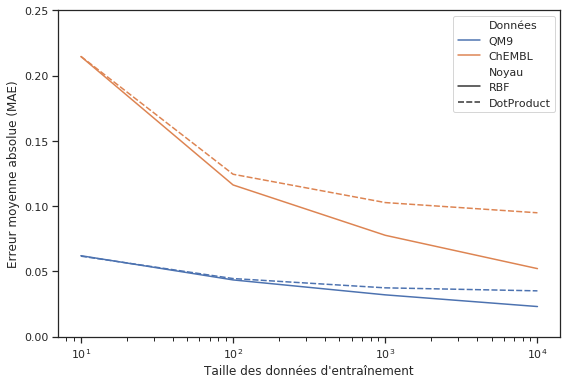

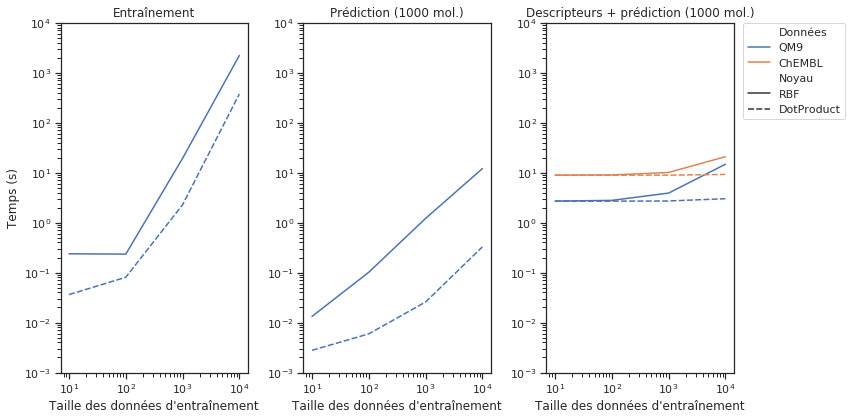

In [74]:
plot_data_efficiency(output_data_efficiency, time_QM9_desc, time_ChEMBL_desc)

In [75]:
output_data_efficiency

{'RBF': {'size': [10, 30, 100, 300, 1000, 3000, 10000],
  'QM9_fit_time': [0.2374424934387207,
   0.07402610778808594,
   0.23396754264831543,
   1.0211646556854248,
   19.34816074371338,
   261.04387402534485,
   2217.5312266349792],
  'QM9_predict_time': [0.6621901988983154,
   1.6630513668060303,
   5.078276872634888,
   14.9529709815979,
   60.57720422744751,
   178.6093282699585,
   600.2998831272125],
  'QM9_MAE': [0.061930349015661586,
   0.053401431189901996,
   0.04337165148534495,
   0.03758961203410254,
   0.03192196406484638,
   0.026797310586006543,
   0.022965827059832526],
  'ChEMBL_fit_time': [0.015428781509399414,
   0.10293221473693848,
   0.25609636306762695,
   1.7725105285644531,
   17.759260177612305,
   126.70215821266174,
   1623.6018073558807],
  'ChEMBL_predict_time': [0.77174973487854,
   1.6434531211853027,
   5.076650381088257,
   15.270702838897705,
   59.257248878479004,
   179.00804615020752,
   597.4002516269684],
  'ChEMBL_MAE': [0.21459218580754066,
 